In [6]:
import datasets
from src.models.components.partmae_v4 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16_dec512d8b
from src.data.components.transforms.multi_crop_v2 import ParametrizedMultiCropV2
from lightning import Fabric
from tqdm import tqdm
from torch import nn, Tensor
import torch
from torch.utils.data import Dataset, DataLoader, default_collate
from torchmetrics import MeanSquaredError, MeanMetric, MetricCollection
from PIL import Image
from lightning.fabric.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import math
import timm
import timm.scheduler
import torch.optim
import logging

logging.basicConfig(level=logging.INFO)

## Overfit Training

In [7]:
class HFDataset(Dataset):
    def __init__(
        self,
        dataset: str,
        name: str,
        split="train",
        img_key: str = "image",
        transform=None,
    ):
        self.ds = datasets.load_dataset(dataset, name, split=split)
        self.transform = transform
        self.img_key = img_key

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.ds[idx][self.img_key])
        return self.ds[idx]

In [12]:
torch.set_float32_matmul_precision("medium")
fabric = Fabric(precision="bf16-mixed")

with fabric.init_module():
    model = PART_mae_vit_base_patch16_dec512d8b(
        sampler="stratified_jittered",
        alpha_ts=0.8,
        mask_ratio=0.75,
        pos_mask_ratio=0.75,
        alpha_t=0.75,
        max_scale_ratio=6.0,
        canonical_img_size=512,
    )
model = fabric.setup(model)

Using bfloat16 Automatic Mixed Precision (AMP)


In [ ]:
B = 8
gV = 2
lV = 6
train_transform = ParametrizedMultiCropV2(n_global_crops=gV, n_local_crops=lV)
dataset = HFDataset("frgfm/imagenette", "160px", transform=train_transform)
train_dataloader = DataLoader(dataset, batch_size=B, shuffle=False)


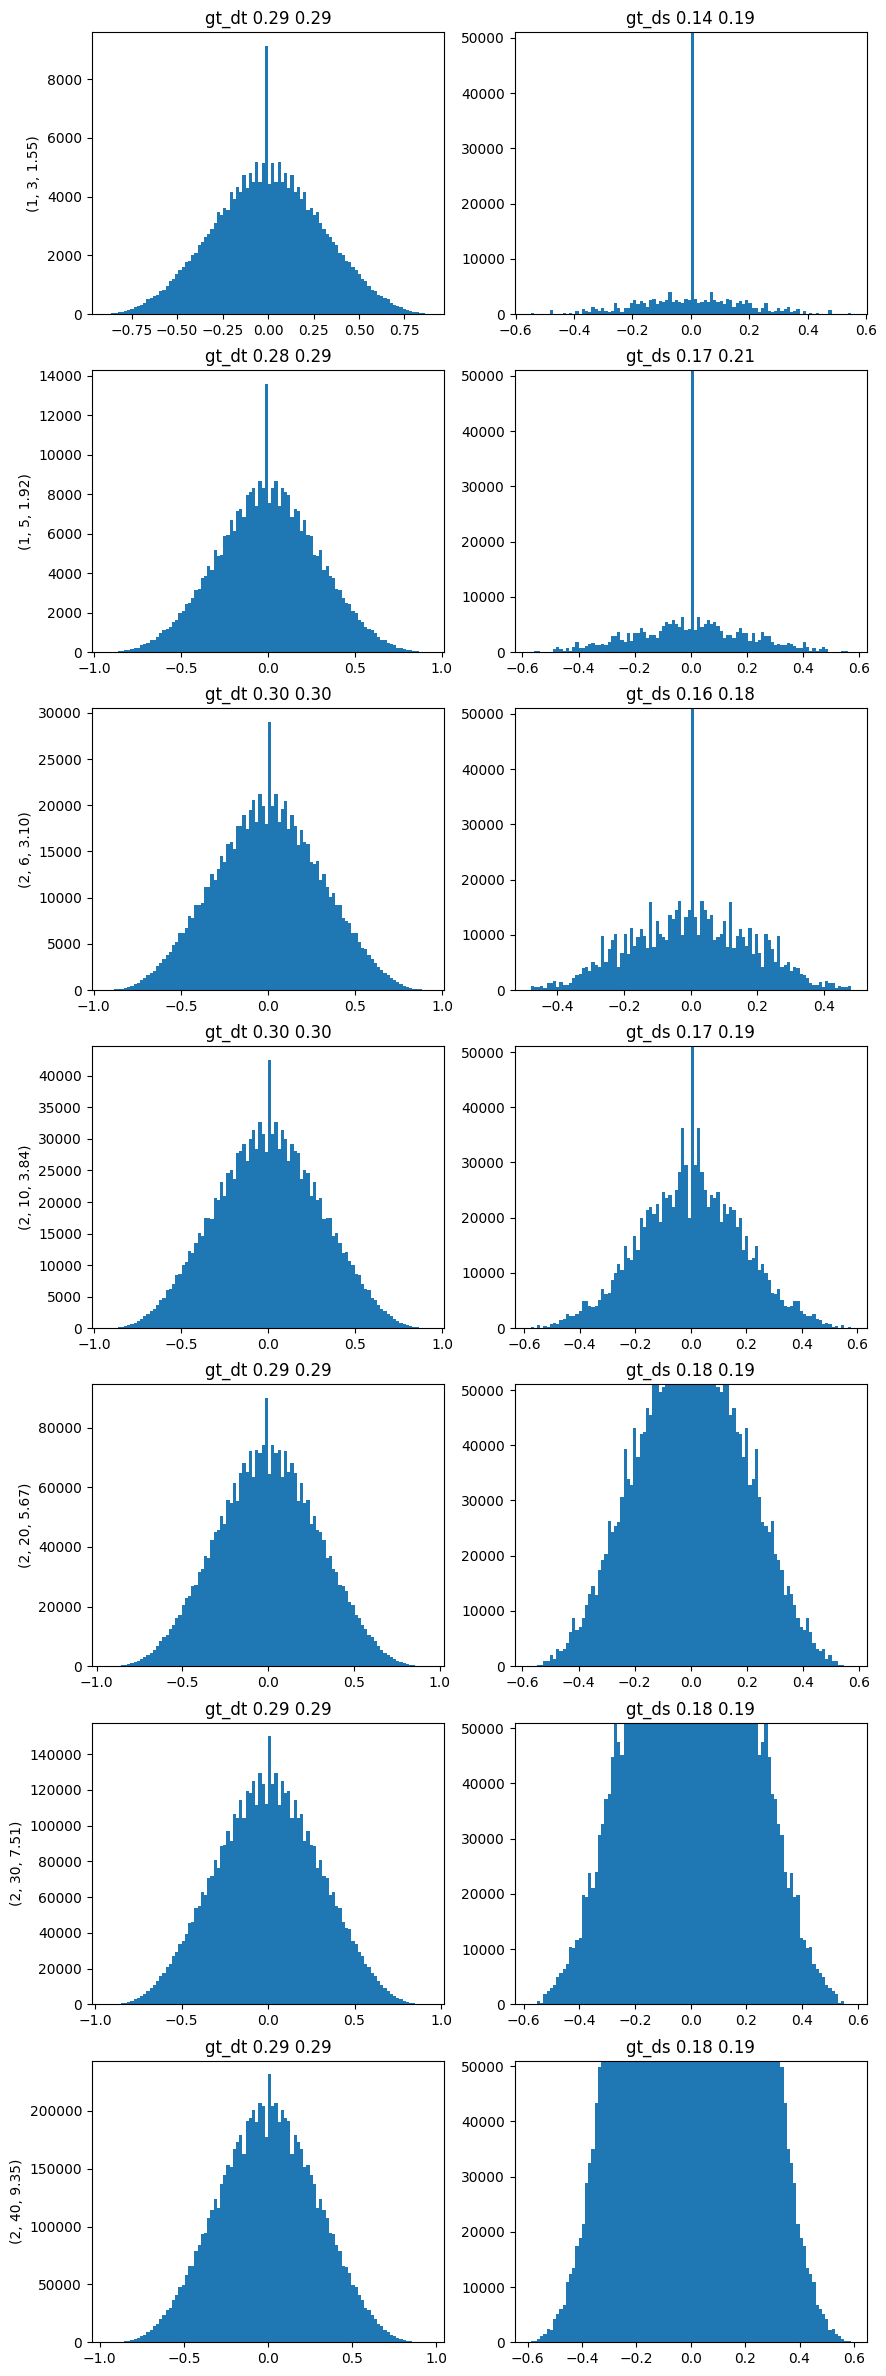

In [54]:
B = 32
params = [(1, 3), (1, 5),  (2, 6), (2, 10),(2, 20), (2, 30), (2, 40)]
fig, ax = plt.subplots(len(params), 2, figsize=(10, 30))

# row titles (param[i][0], param[i][1]) from the left
for i, (gV, lV) in enumerate(params):
    V = gV + lV * (96 * 96) / (224 * 224)
    ax[i, 0].set_ylabel(f"({gV}, {lV}, {V:.2f})")

for i, (gV, lV) in enumerate(params):
    train_transform = ParametrizedMultiCropV2(n_global_crops=gV, n_local_crops=lV)
    dataset = HFDataset("frgfm/imagenette", "160px", transform=train_transform)
    train_dataloader = DataLoader(dataset, batch_size=B, shuffle=False)


    dataloader = fabric.setup_dataloaders(train_dataloader)
    batch = next(iter(dataloader))
    with torch.no_grad():
        out = model(*batch)

    gt_dt = out["gt_dT"][..., :2].detach().cpu()
    gt_ds = out["gt_dT"][..., 2:].detach().cpu()

    ax[i, 0].hist(gt_dt.flatten(), bins=100)
    gt_dt_std = gt_dt.std()
    gt_dt_std_nonzero = gt_dt[gt_dt != 0].std()
    ax[i, 0].set_title(f"gt_dt {gt_dt_std:.2f} {gt_dt_std_nonzero:.2f}")
    ax[i, 1].hist(gt_ds.flatten(), bins=100)
    gt_ds_std = gt_ds.std()
    gt_ds_std_nonzero = gt_ds[gt_ds != 0].std()
    ax[i, 1].set_title(f"gt_ds {gt_ds_std:.2f} {gt_ds_std_nonzero:.2f}")
    # set y limit to be the same
    ax[i, 1].set_ylim([0, 51000])
